## Import required libraries

In [17]:
import cv2
import copy
import numpy as np
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

## FF-UNet model

In [18]:
def expend_as(x, n):
    y = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': n})(x)
    return y

def conv_bn_act(x, filters, drop_out=0.0):
    x = Conv2D(filters, (3, 3), activation=None, padding='same')(x)

    if drop_out > 0:
        x = Dropout(drop_out)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def attention_layer(d, e, n):
    d1 = Conv2D(n, (1, 1), activation=None, padding='same')(d)
    e1 = Conv2D(n, (1, 1), activation=None, padding='same')(e)

    concat_de = add([d1, e1])

    relu_de = Activation('relu')(concat_de)
    conv_de = Conv2D(1, (1, 1), padding='same')(relu_de)
    sigmoid_de = Activation('sigmoid')(conv_de)

    shape_e = K.int_shape(e)
    upsample_psi = expend_as(sigmoid_de, shape_e[3])

    return multiply([upsample_psi, e])

def feature_fused_module(x, filters, compression=0.5, drop_out=0.0):
    x1 = Conv2D(filters, (3, 3), dilation_rate=2, padding='same')(x)

    if drop_out > 0:
        x1 = Dropout(drop_out)(x1)

    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(filters, (3, 3), padding='same')(x)

    if drop_out > 0:
        x2 = Dropout(drop_out)(x2)

    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    x3 = add([x1, x2])

    x3 = GlobalAveragePooling2D()(x3)

    x3 = Dense(int(filters * compression))(x3)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)

    x3 = Dense(filters)(x3)

    x3p = Activation('sigmoid')(x3)

    x3m = Lambda(lambda x: 1 - x)(x3p)

    x4 = multiply([x1, x3p])
    x5 = multiply([x2, x3m])

    return add([x4, x5])

def FF_UNet(input_shape=(256, 256, 3), filters=16, compression=0.5, drop_out=0, half_net=False, attention_gates=False):

    inputShape = Input(input_shape)

    c1 = feature_fused_module(inputShape, filters, compression=compression, drop_out=drop_out)
    c1 = feature_fused_module(c1, filters, compression=compression, drop_out=drop_out)
    p1 = MaxPooling2D((2, 2))(c1)
    filters = 2 * filters

    c2 = feature_fused_module(p1, filters, compression=compression, drop_out=drop_out)
    c2 = feature_fused_module(c2, filters, compression=compression, drop_out=drop_out)
    p2 = MaxPooling2D((2, 2))(c2)
    filters = 2 * filters

    c3 = feature_fused_module(p2, filters, compression=compression, drop_out=drop_out)
    c3 = feature_fused_module(c3, filters, compression=compression, drop_out=drop_out)
    p3 = MaxPooling2D((2, 2))(c3)
    filters = 2 * filters

    c4 = feature_fused_module(p3, filters, compression=compression, drop_out=drop_out)
    c4 = feature_fused_module(c4, filters, compression=compression, drop_out=drop_out)
    p4 = MaxPooling2D((2, 2))(c4)
    filters = 2 * filters

    cm = feature_fused_module(p4, filters, compression=compression, drop_out=drop_out)
    cm = feature_fused_module(cm, filters, compression=compression, drop_out=drop_out)

    filters = filters // 2

    u4 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(cm)

    if attention_gates:
        u4 = concatenate([u4, attention_layer(u4, c4, 1)], axis=3)
    else:
        u4 = concatenate([u4, c4], axis=3)

    if half_net:
        c5 = conv_bn_act(u4, filters, drop_out=drop_out)
        c5 = conv_bn_act(c5, filters, drop_out=drop_out)
    else:
        c5 = feature_fused_module(u4, filters, compression=compression, drop_out=drop_out)
        c5 = feature_fused_module(c5, filters, compression=compression, drop_out=drop_out)

    filters = filters // 2

    u3 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(c5)

    if attention_gates:
        u3 = concatenate([u3, attention_layer(u3, c3, 1)], axis=3)
    else:
        u3 = concatenate([u3, c3], axis=3)

    if half_net:
        c6 = conv_bn_act(u3, filters, drop_out=drop_out)
        c6 = conv_bn_act(c6, filters, drop_out=drop_out)
    else:
        c6 = feature_fused_module(u3, filters, compression=compression, drop_out=drop_out)
        c6 = feature_fused_module(c6, filters, compression=compression, drop_out=drop_out)

    filters = filters // 2

    u2 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(c6)

    if attention_gates:
        u2 = concatenate([u2, attention_layer(u2, c2, 1)], axis=3)
    else:
        u2 = concatenate([u2, c2], axis=3)

    if half_net:
        c7 = conv_bn_act(u2, filters, drop_out=drop_out)
        c7 = conv_bn_act(c7, filters, drop_out=drop_out)

    else:
        c7 = feature_fused_module(u2, filters, compression=compression, drop_out=drop_out)
        c7 = feature_fused_module(c7, filters, compression=compression, drop_out=drop_out)

    filters = filters // 2

    u1 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(c7)

    if attention_gates:
        u1 = concatenate([u1, attention_layer(u1, c1, 1)], axis=3)
    else:
        u1 = concatenate([u1, c1], axis=3)

    if half_net:
        c8 = conv_bn_act(u1, filters, drop_out=drop_out)
        c8 = conv_bn_act(c8, filters, drop_out=drop_out)
    else:
        c8 = feature_fused_module(u1, filters, compression=compression, drop_out=drop_out)
        c8 = feature_fused_module(c8, filters, compression=compression, drop_out=drop_out)

    c9 = Conv2D(1, (1, 1), padding="same", activation='sigmoid')(c8)

    return Model(inputs=[inputShape], outputs=[c9])

## Visualize model

In [19]:
model = FF_UNet(attention_gates=False)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 256, 256, 16) 64          conv2d_37[0][0]                  
____________________________________________________________________________________________

## Load pre-trained weight

In [20]:
## Download pre-trained weight: https://drive.google.com/file/d/1FzRmNzoSxxNbvvSsUFMYrCwCqQTF58JO

model.load_weights('FF_UNet_weight.h5')

## Dice coefficient

In [51]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))

## Read Image

In [48]:
img_org = cv2.imread('test_images/img_1610.png', cv2.IMREAD_COLOR)

# Polyp Image
img = img_org.copy()
img = img/255.0
img = np.expand_dims(img, axis=0)

# Ground Truth
roi = cv2.imread('test_images/mask_1610.png', 0)
roi = roi/255.0

# Shape
print('image shape:', img.shape, 'roi shape:', roi.shape)

image shape: (1, 256, 256, 3) roi shape: (256, 256)


## Prediction

In [49]:
roi_predicted = model.predict(img).squeeze().round().astype('uint8')

print('Dice coefficient:', dice_coef(roi_predicted, roi).round(3))

Dice coefficient: 0.979


## Plot Prediction

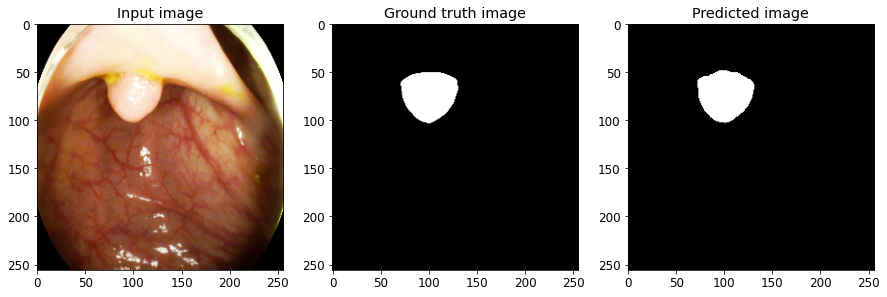

In [52]:
plt.rcParams["figure.figsize"] = (15, 15)
plt.rc('font', size=12)
plt.figure()
plt.subplot(131)
plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB))
plt.title('Input image')
plt.subplot(132)
plt.title('Ground truth image')
plt.imshow(roi, cmap='gray')
plt.subplot(133)
plt.title('Predicted image')
plt.imshow(roi_predicted, cmap='gray')
plt.show()